# Local ToE

- In this version I have added in the other tests (KS, Anerson Darling)

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs


# My imports
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
               
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import stats
import time_of_emrgence_calc as toe
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /jobfs/111963638.gadi-pbs/matplotlib-prj4hpln because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
# client.close()

In [ ]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
# Scale the client to have n workers workers
client.cluster.scale(28)
client

- State start
- Found stale lock file and directory '/jobfs/111963638.gadi-pbs/dask-scratch-space/scheduler-6iocdkrw', purging
- Found stale lock file and directory '/jobfs/111963638.gadi-pbs/dask-scratch-space/worker-_4ji0syq', purging
- Found stale lock file and directory '/jobfs/111963638.gadi-pbs/dask-scratch-space/worker-vb6ojnk9', purging
-   Scheduler at:     tcp://127.0.0.1:46313
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:38259'
-         Start Nanny at: 'tcp://127.0.0.1:34321'
-         Start Nanny at: 'tcp://127.0.0.1:39985'
-         Start Nanny at: 'tcp://127.0.0.1:40395'
-         Start Nanny at: 'tcp://127.0.0.1:44553'
-         Start Nanny at: 'tcp://127.0.0.1:42443'
-         Start Nanny at: 'tcp://127.0.0.1:39987'
-         Start Nanny at: 'tcp://127.0.0.1:37701'
-         Start Nanny at: 'tcp://127.0.0.1:38081'
-         Start Nanny at: 'tcp://127.0.0.1:36585'
-         Start Nanny at: 't

In [ ]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

# Opening Best

In [ ]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'
os.listdir(os.path.join(ROOT_DIR, 'best'))

In [ ]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon'})
best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()

In [ ]:
# Only 43MB - load into memory
best_ds = best_ds.compute()

In [ ]:
best_ds.isel(time=[0, 30, 100]).plot(col='time')

In [ ]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

In [ ]:
base_period_ds_count = base_period_ds.count(dim='time')

In [ ]:
data_availability_levels = np.arange(0, 61, 10)

base_period_ds_count.plot(levels=data_availability_levels)

In [ ]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

In [ ]:
data_availability_mask.plot()

In [ ]:
# Apply the mask to both the base period and the full dataset
best_ds = best_ds.where(data_availability_mask)

base_period_ds = base_period_ds.where(data_availability_mask)

# Calculations

In [ ]:
window = 20

## Signal-to-Noise

### Trend Fit

In [14]:
best_ds_no_base = best_ds.sel(time=best_ds.time.dt.year>1900)
best_ds_no_base

<xarray.DataArray 'temperature' (time: 124, lat: 180, lon: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1901-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes:
    long_name:      Air Surface Temperature Anomaly
    standard_name:  surface_temperature_anomaly
    units:          degree C
    valid_max:      25.701491748794503
    valid_min:      -20.130122807817852

In [15]:
import statsmodels.api as sm 
lowess = sm.nonparametric.lowess

In [16]:
def apply_lowess(arr):
    if all(np.isnan(arr)): return arr

    x = np.arange(arr.shape[0])
    yhat = lowess(arr,x, return_sorted=False)
    return yhat

In [18]:
best_ds_no_base = best_ds_no_base.chunk({'time':-1, 'lat':25, 'lon':25})
best_ds_no_base

<xarray.DataArray 'temperature' (time: 124, lat: 180, lon: 360)>
dask.array<xarray-<this-array>, shape=(124, 180, 360), dtype=float32, chunksize=(124, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1901-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

In [19]:
%%time
ds_best_trend_fitted = xr.apply_ufunc(
    apply_lowess,
    best_ds_no_base,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized'
).compute()

CPU times: user 4.51 s, sys: 939 ms, total: 5.45 s
Wall time: 22.8 s


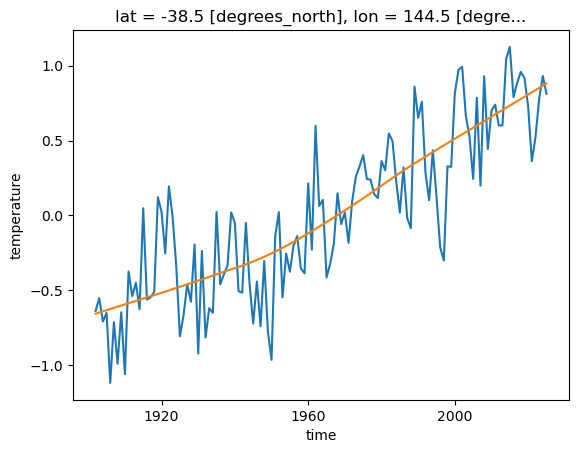

In [20]:
best_ds_no_base.sel(lat=-39, lon=144, method='nearest').plot()
ds_best_trend_fitted.sel(lat=-39, lon=144, method='nearest').plot()

In [128]:
# As these are anomalies, the signal is just going to be the
# ds_best_poly = stats.trend_fit(best_ds_no_base, method='POLYNOMIAL', order=4)#'LOWESS', lowess_window=40)

In [129]:
# Example of polyfit failing even when there is only one nan
# stats.trend_fit(best_ds.sel(lat=-55, lon=-150, method='nearest')e, method='POLYNOMIAL', order=4)

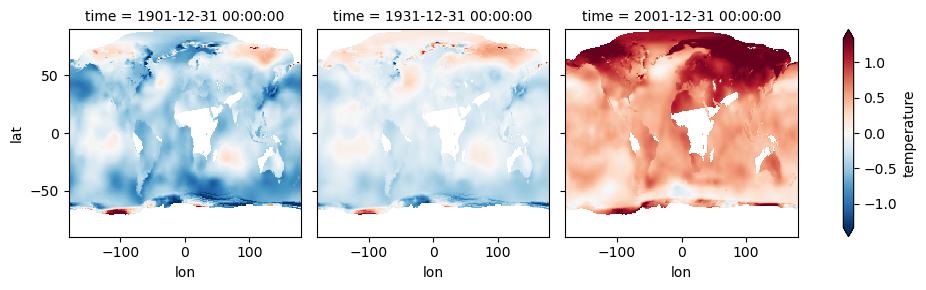

In [21]:
ds_best_trend_fitted.isel(time=[0, 30, 100]).plot(col='time', robust=True)

In [22]:
noise_ds = base_period_ds.std(dim='time')

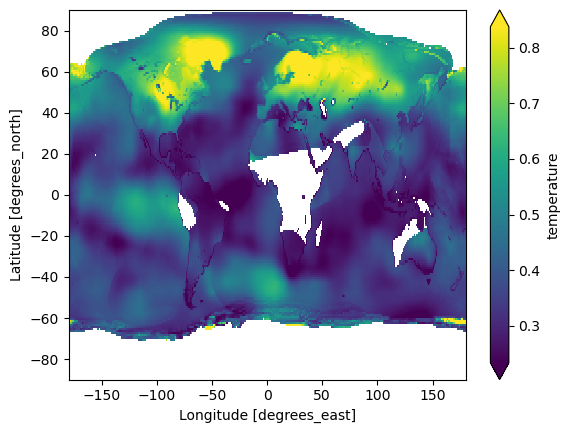

In [23]:
noise_ds.plot(robust=True)

In [24]:
base_period_ds_average = base_period_ds.mean(dim='time').fillna(0)
base_period_ds_average

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [25]:
ds_best_signal = ds_best_trend_fitted - base_period_ds_average

In [26]:
ds_best_sn = ds_best_signal/noise_ds

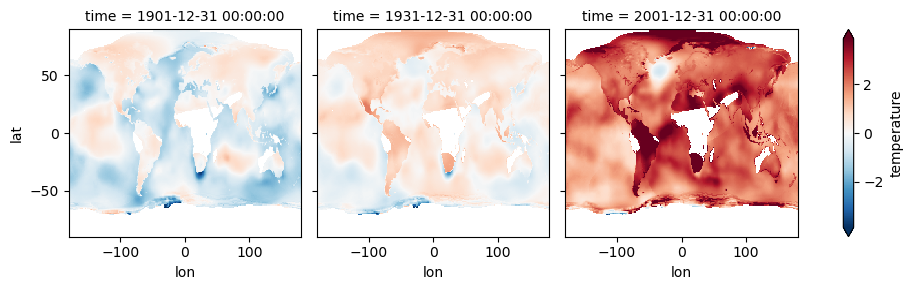

In [27]:
ds_best_sn.isel(time=[0, 30, 100]).plot(col='time', robust=True)

## p-value tests

In [56]:
#### LEGACY - this can be used for verificaiton, but currently the two version do the same thing
# # Note this was failing before due to bad chunking
# ### T-test using 1D array funcs
# stats_test_1d_array_ttest = partial(toe.stats_test_1d_array, stats_func=toe.return_ttest_pvalue)

# ufunc_kwargs = dict(
#     input_core_dims=[['time']],
#     output_core_dims=[['time']], 
#     vectorize=True,
#     dask='parallelized')


# ttest_1d_ds_subset = xr.apply_ufunc(
#     stats_test_1d_array_ttest,
#     best_ds.sel(lat=slice(-45, -35), lon=slice(135, 160)),
#     **ufunc_kwargs).compute()

- Event loop was unresponsive in Nanny for 10.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 10.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 10.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 10.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 10.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 10.35s.  This is often caused by long

In [57]:
CHUNKS_FOR_PVALUE_TESTS =  {'lat':25, 'lon':25, 'time':-1}
CHUNKS_FOR_PVALUE_TESTS

{'lat': 25, 'lon': 25, 'time': -1}

In [58]:
best_ds_window = best_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rolling(time=window).construct('window_dim').persist()#.sel(lat=slice(-45, -35), lon=slice(135, 160))#[(window-1):]
base_period_window_ds = base_period_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).rename({'time':'window_dim'}).persist()#.sel(lat=slice(-45, -35), lon=slice(135, 160))

In [59]:
base_period_window_ds

<xarray.DataArray 'temperature' (window_dim: 50, lat: 10, lon: 25)>
dask.array<getitem, shape=(50, 10, 25), dtype=float32, chunksize=(50, 5, 15), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 -44.5 -43.5 -42.5 -41.5 ... -37.5 -36.5 -35.5
  * lon         (lon) float32 135.5 136.5 137.5 138.5 ... 157.5 158.5 159.5
  * window_dim  (window_dim) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [60]:
best_ds_window

<xarray.DataArray 'temperature' (time: 175, lat: 10, lon: 25, window_dim: 20)>
dask.array<getitem, shape=(175, 10, 25, 20), dtype=float32, chunksize=(175, 5, 15, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -43.5 -42.5 -41.5 ... -38.5 -37.5 -36.5 -35.5
  * lon      (lon) float32 135.5 136.5 137.5 138.5 ... 156.5 157.5 158.5 159.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Dimensions without coordinates: window_dim
Attributes: (5)

In [61]:
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [62]:
%%time
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

- Event loop was unresponsive in Nanny for 6.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.40s.  This is often caused by long-runni

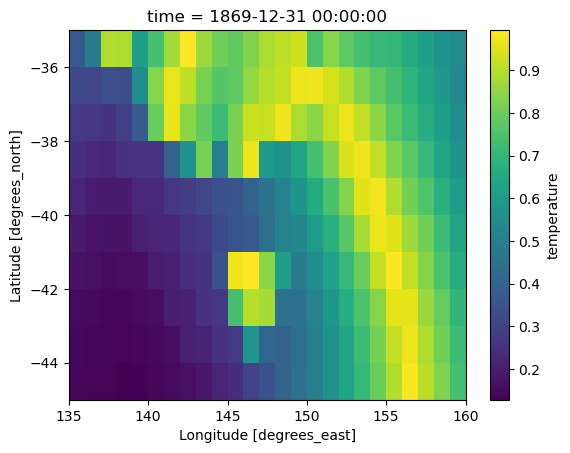

In [64]:
ttest_1d_ds_subset.isel(time=19).plot()

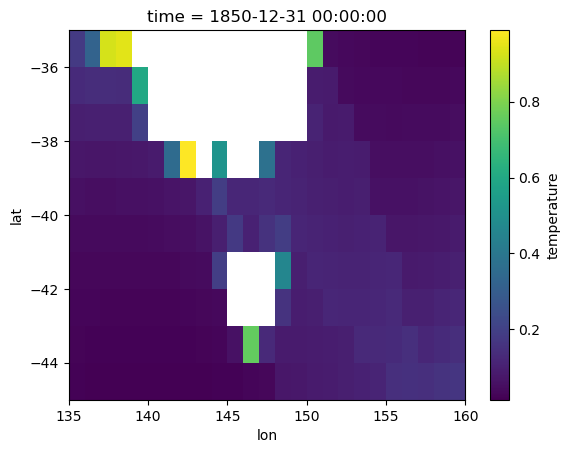

In [63]:
ttest_ds.isel(time=0).plot()

In [39]:
%%time
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 10.3 s, sys: 1.94 s, total: 12.3 s
Wall time: 51.1 s


In [40]:
# ks_2samp will perfom on all nan slices
ks_ds = ks_ds.where(data_availability_mask)

In [41]:
anderson_ds = ks_ds

In [42]:
PVALUE_THESHOLD1 = 0.01

In [43]:
# Finding when each test does not emerge
sn_does_not_emerge = (ds_best_sn_poly.isel(time=-1) <= 2)

ks_does_not_emerge = (ks_ds.isel(time=-1) >= PVALUE_THESHOLD1)

ttest_does_not_emerge = (ttest_ds.isel(time=-1) >= PVALUE_THESHOLD1)

anderson_does_not_emerge = (anderson_ds.isel(time=-1) >= PVALUE_THESHOLD1)

NameError: name 'ds_best_sn_poly' is not defined

In [ ]:
# Find the year of permanent exceedance
sn_toe_ds = toe.get_permanent_exceedance(ds_best_sn_poly, threshold=2, comparison_func=np.greater)

ks_toe_ds = toe.get_permanent_exceedance(ks_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

ttest_toe_ds = toe.get_permanent_exceedance(ttest_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

anderson_toe_ds = toe.get_permanent_exceedance(anderson_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

# Explorign Odd Patterns

In [22]:
time_indices = np.array([0, 50, 100, 150])

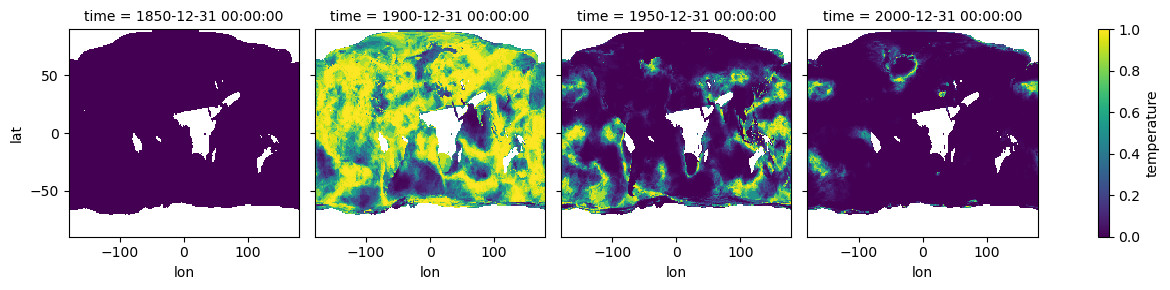

In [79]:
ks_ds.isel(time=time_indices).plot(col='time')

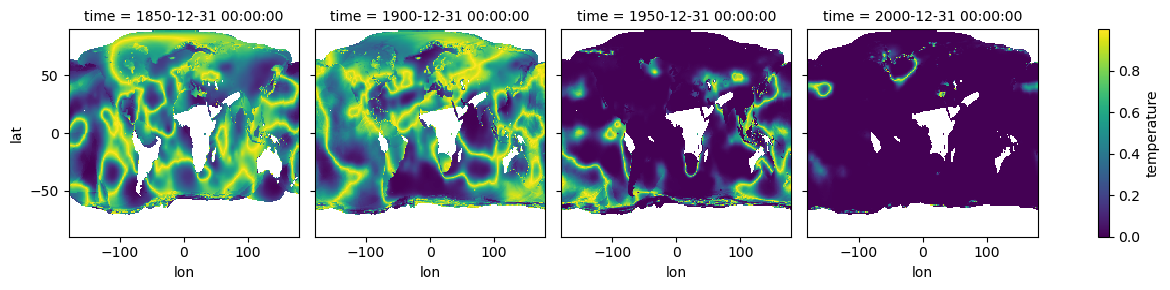

In [24]:
ttest_ds.isel(time=time_indices).plot(col='time')

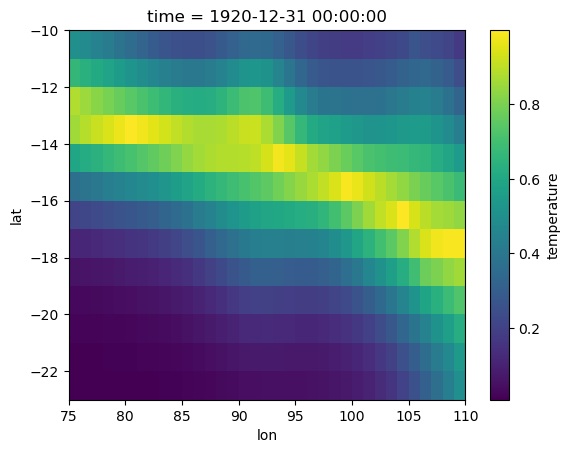

In [34]:
test_sample_ds = ttest_ds.isel(time=70).sel(lat=slice(-22.5, -10), lon=slice(75, 110))
test_sample_ds.plot()

In [35]:
min_loc = test_sample_ds.where(test_sample_ds == test_sample_ds.min().values, drop=True)
min_lat = min_loc.lat.values[0]
min_lon = min_loc.lon.values[0]
min_lon, min_lat

(77.5, -22.5)

In [36]:
max_loc = test_sample_ds.where(test_sample_ds == test_sample_ds.max().values, drop=True)
max_lat = max_loc.lat.values[0]
max_lon = max_loc.lon.values[0]
max_lon, max_lat

(104.5, -16.5)

In [37]:
min_time_series = best_ds.sel(lat=min_lat, lon=min_lon)
max_time_series = best_ds.sel(lat=max_lat, lon=max_lon)

In [38]:
min_series_pvals = xr.zeros_like(min_time_series) + toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue)
max_series_pvals = xr.zeros_like(max_time_series) + toe.stats_test_1d_array(max_time_series, stats_func=toe.return_ttest_pvalue)

In [42]:
def color_yaxis(axis, color, side='left'):
    if not isinstance(axis, list): axis = [axis]
    for ax in axis:
        ax.spines[side].set_color(color)
        ax.tick_params(axis='y', color=color, labelcolor=color)

Text(0, 0.5, 'Temperature\nAnomaly')

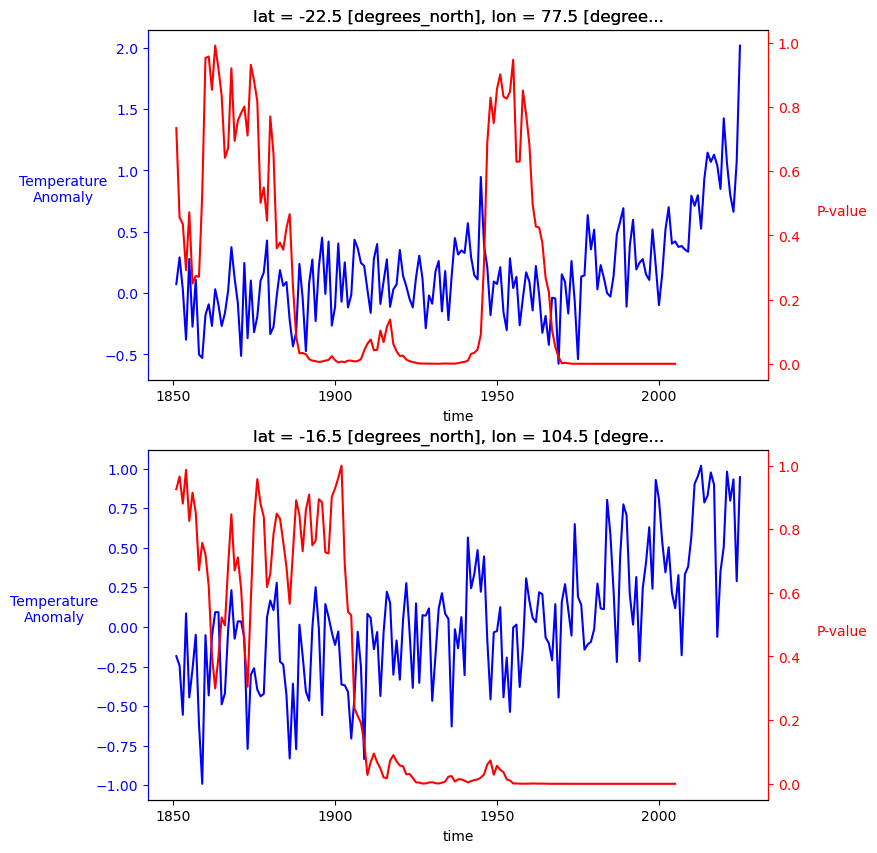

In [43]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 10), nrows=2, ncols=1)

ax1_twinx = ax1.twinx()
min_time_series.plot(ax=ax1, color='blue')
min_series_pvals.plot(ax=ax1_twinx, color='red')
color_yaxis([ax1, ax1_twinx], 'blue', 'left')
color_yaxis([ax1_twinx], 'red', 'right')
ax1_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax1.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

ax2_twinx = ax2.twinx()
max_time_series.plot(ax=ax2, color='blue')
max_series_pvals.plot(ax=ax2_twinx, color='red')
color_yaxis([ax2, ax2_twinx], 'blue', 'left')
color_yaxis([ax2_twinx], 'red', 'right')
ax2_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax2.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

# Getting ToE

In [95]:
grey_white_cmap = mcolors.LinearSegmentedColormap.from_list('grey_white_cmap',  [(1, 1, 1), (0.5, 0.5, 0.5)] , N=2)

In [96]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

In [97]:
not_stable_kwargs2 = dict(cmap= grey_white_cmap, add_colorbar=False)

Text(0.5, 1.0, 'Anderson')

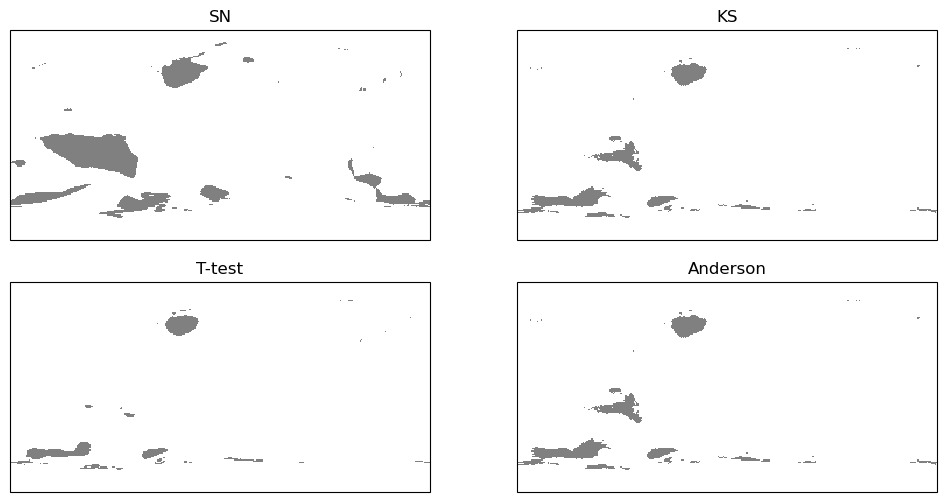

In [98]:
fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(2,2,i, projection=ccrs.PlateCarree()) for i in range(1,5)]

sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs2)
ks_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs2)
ttest_does_not_emerge.plot(ax=axes[2], **not_stable_kwargs2)
anderson_does_not_emerge.plot(ax=axes[3], **not_stable_kwargs2)
axes[0].set_title('SN')
axes[1].set_title('KS')
axes[2].set_title('T-test')
axes[3].set_title('Anderson')

In [99]:
def hatch(ax, ds, **kwargs):
    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, **kwargs)

In [100]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

In [101]:
data_unavailability_mask = xr.where(data_availability_mask, False, True)

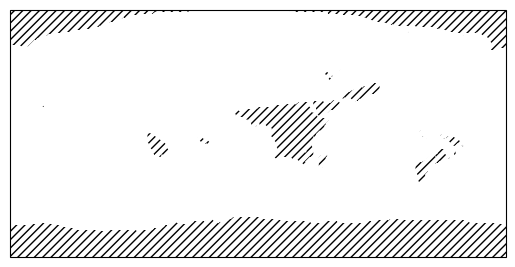

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
hatch(ax, xr.where(data_availability_mask, False, True), **not_stable_kwargs)

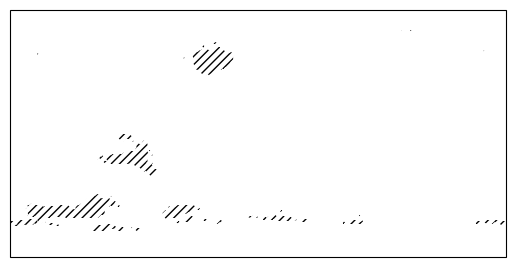

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
hatch(ax, ks_does_not_emerge, **not_stable_kwargs)

## Comparison

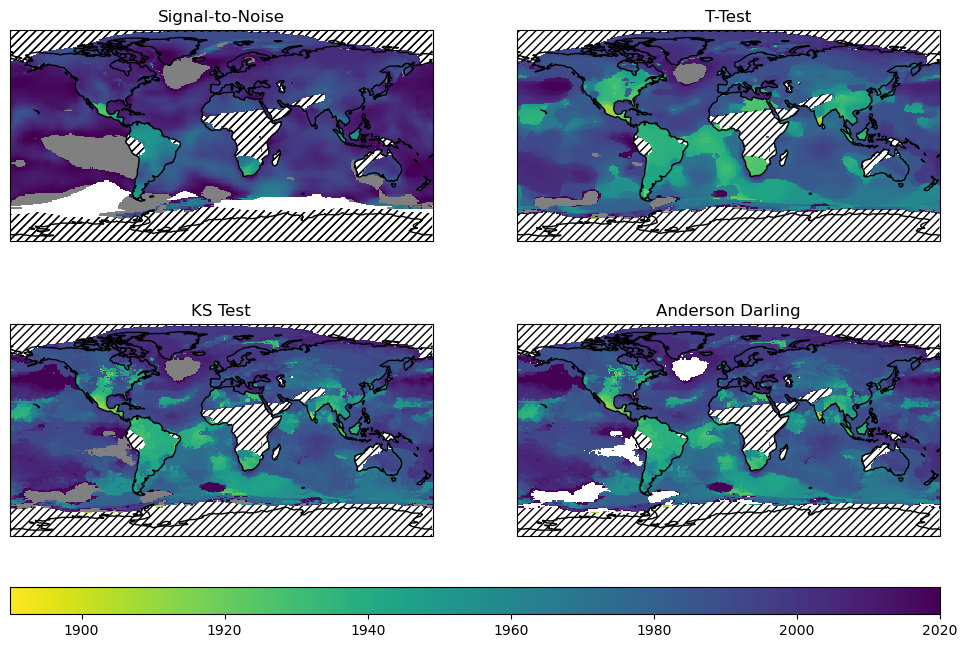

In [104]:
fig = plt.figure(figsize=(12, 8))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(4)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

# Signal-to-noise
sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs2)
sn_toe_ds.plot(ax=axes[0], **toe_plot_kwargs)
axes[0].set_title('Signal-to-Noise')
hatch(axes[0], data_unavailability_mask, **not_stable_kwargs)

# T-test
ttest_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs2)
ttest_toe_ds.plot(ax=axes[1], **toe_plot_kwargs)
axes[1].set_title('T-Test')
hatch(axes[1], xr.where(data_availability_mask, 0, 1), **not_stable_kwargs)


# KS Test
ks_does_not_emerge.plot(ax=axes[2], **not_stable_kwargs2)
toe_plot = ks_toe_ds.plot(ax=axes[2], **toe_plot_kwargs)
axes[2].set_title('KS Test')
# hatch(axes[2], ks_does_not_emerge, **not_stable_kwargs)


# Anderson Darling
anderson_toe_ds.plot(ax=axes[3], **toe_plot_kwargs)
axes[3].set_title('Anderson Darling')

cbar_axes1 = plt.subplot(gs[2, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

for ax in axes:
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)


Text(0.5, 1.0, 'Difference (SN - KS)')

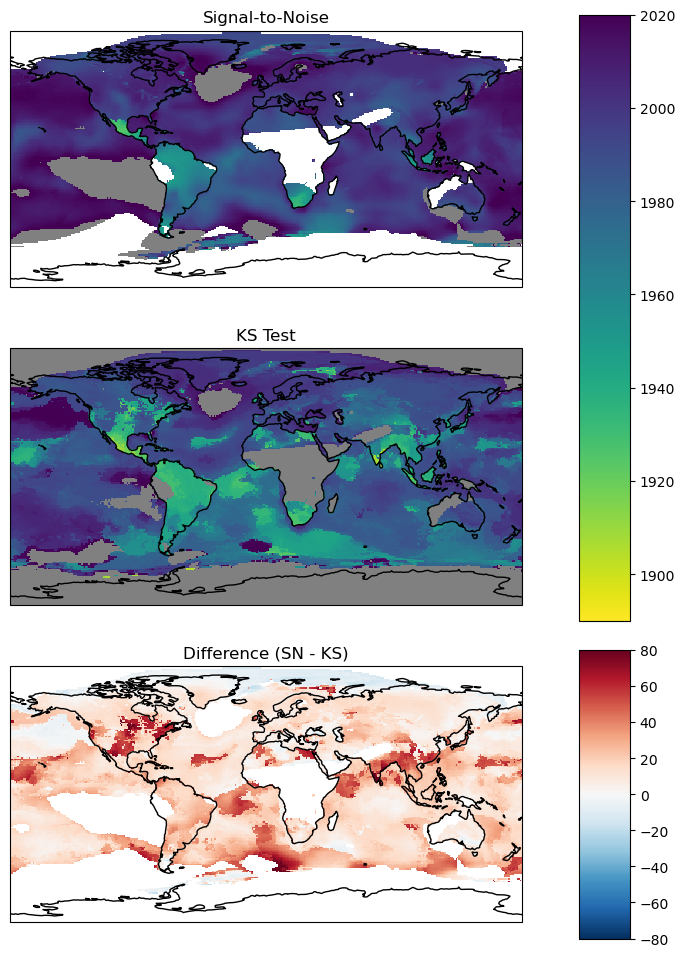

In [68]:
fig = plt.figure(figsize=(8, 12))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(3)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs)
ks_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs)


sn_toe_ds.plot(ax=axes[0], **toe_plot_kwargs)
toe_plot = ks_toe_ds.plot(ax=axes[1], **toe_plot_kwargs)

cbar_axes1 = plt.subplot(gs[:2, 1])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')

diff_plot = (sn_toe_ds - ks_toe_ds).plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[2, 1])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='vertical')

for ax in axes: ax.coastlines()

axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

In [ ]:
fig = plt.figure(figsize=(16, 4))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(2, 3, height_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[0, i], projection=projection) for i in range(3)]

sn_toe_ds.plot(ax=axes[0], add_colorbar=False, vmin=1850, vmax=2010)
toe_plot = ks_toe_ds.plot(ax=axes[1], add_colorbar=False, vmin=1850, vmax=2010)

cbar_axes1 = plt.subplot(gs[1, :2])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

diff_plot = (sn_toe_ds - ks_toe_ds).plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[1, 2])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='horizontal')


axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

In [ ]:
lat=3.263204
lon=12.78272

In [ ]:
selection_kwargs = dict(lat=lat, lon=lon, method='nearest')

In [ ]:
ks_toe_ds

In [ ]:
ks_toe_ds.sel(**selection_kwargs).values

In [ ]:
sn_toe_ds.sel(**selection_kwargs).values

In [ ]:
best_ds.sel(**selection_kwargs).plot()